<a href="https://colab.research.google.com/github/Jayesh1211/PASQAL_HACK/blob/main/MDP_Planning_toy_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Markov Decision Process (MDP) Formalism**

The **Markov Decision Process (MDP)** is a mathematical framework used to model decision-making in environments where outcomes are partly random and partly under the control of a decision-maker. In the context of **CO₂ hydrogenation to methanol**, we use MDP to optimize the reaction pathway by:

- **States $s$**: Representing molecular species ($A_0, A_1$, etc).
- **Actions $a$**: Representing competing reaction pathways (e.g., $A_0 → B_0$, or  $A_0 → B_1$)
- **Transition Probabilities $P(s,s')$**: Representing the likelihood of moving from one state to another.
- **Reward Function $R(s,a,s')$**: Assigning rewards for reaching desired products (e.g., $E_0$) and penalties for undesired byproducts (e.g., $B_1, C_1$ etc).
- **Discount Factor ( $\gamma$)**: Balancing immediate and future rewards (set to 0.95 in this case).

The goal is to compute an **optimal policy** that maximizes the cumulative reward, thereby favoring the production of methanol over byproducts.


In the instance shown in this notebook,

In [21]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import cvxpy as cp

# Toy Graph MDP

In [22]:
# =========================
#  Step 1 : Define the MDP
# ==========================

states = [0, 1, 2, 3, 4, 5, 6,7,8]  # Nodes representing molecules

# Define labels for the molecules
node_labels = {
    0: "A_0", # source
    1: "B_0",
    2: "C_O",
    3: "D_O",
    4: "E_0",  # Desired product
    5: "B_1",  # Byproduct --Terminal state
    6: "C_1",  # Byproduct --Terminal state
    7: "D_1",  # Byproduct --Terminal state
    8: "E_1"  # Byproduct --Terminal state
}

actions = {
    0: [1,5],     # A_0 → B_0, or A_0 → B_1
    1: [2,6],     # B_0 → C_0, or B_0 → C_1
    2: [3,7],     # C_0 → D_0, or C_0 → D_1
    3: [4,8],     # D_0 → E_0, or D_0 → E_1
    4: [],         # Desired product (E_0)
    5: [],         # Undesired byproduct (B_1)
    6: [],         # Undesired byproduct (C_1)
    7: [],         # Undesired byproduct (D_1)
    8: [],         # Undesired byproduct (E_1)

    }

gamma = 0.95  # Discount factor

R = {4: 1 , 5:-1, 6: -1,7:-1, 8: -1}  # Rewards (1 for methanol, -1 for byproducts)
default_reward = 0.1  # Small reward for other states

# Compute transition probabilities
P = {
    (0,1) : 0.9,
    (0,5) : 0.1,
    (1,2) : 0.8,
    (1,6) : 0.2,
    (2,3) : 0.5,
    (2,7) : 0.5,
    (3,4) : 0.25,
    (3,8) : 0.75

}

# Call the visualization function before running algorithms

#visualize_mdp(states, actions, P, R,gamma, node_labels,pos1)

In [23]:
print(P)

{(0, 1): 0.9, (0, 5): 0.1, (1, 2): 0.8, (1, 6): 0.2, (2, 3): 0.5, (2, 7): 0.5, (3, 4): 0.25, (3, 8): 0.75}


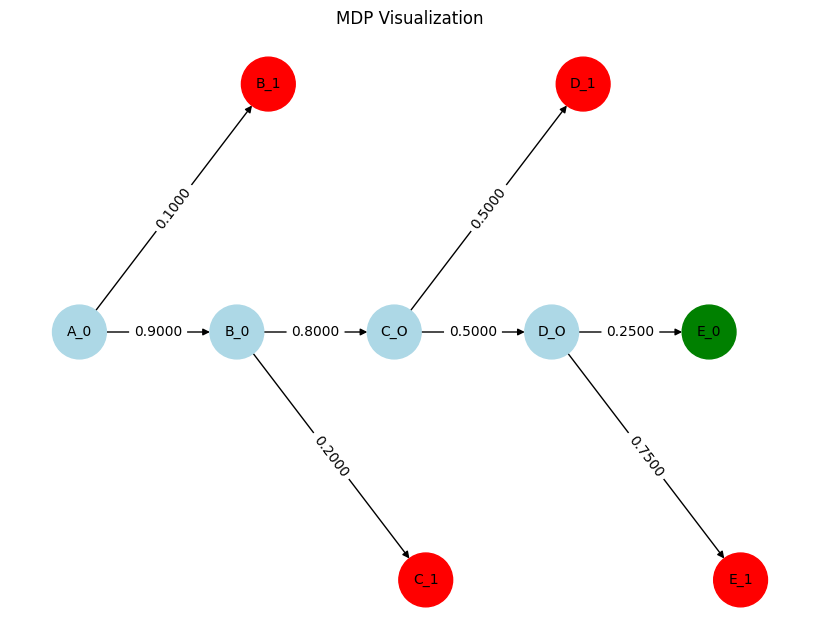

In [24]:
# Visualization Function


pos = { ## Position of graph/ MDP nodes in the visualization
        0: (0, 0),
        1: (1, 0),
        2: (2, 0),
        3: (3, 0),
        4: (4, 0),
        5: (1.2, 0.5),
        6: (2.2, -0.5),
        7: (3.2, 0.5),
        8: (4.2, -0.5)
    }
def visualize_mdp(states, actions, P, R, gamma, node_labels,pos):
    G = nx.DiGraph()
    for s in states:
        if s not in R:
          color1 = 'lightblue'
        elif R[s] > 0:
          color1 = 'green'
        else:
          color1 = 'red'
        G.add_node(s, color=color1)

    for (s, s_next), prob in P.items():

      # Check if nodes exist before adding edges and attributes
        if s not in G.nodes:
            G.add_node(s, color='lightblue')  # Default color if not in states
        if s_next not in G.nodes:
            G.add_node(s_next, color='lightblue')  # Default color if not in states
        G.add_edge(s, s_next, weight=prob, label=f'{prob:.4f}')



    node_colors = [G.nodes[n]['color'] for n in G.nodes]
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_color=node_colors, node_size=1500, edge_color='black',font_size = 10)
    #nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1000, edge_color='black')
    edge_labels = {(s, s_next): G[s][s_next]['label'] for s, s_next in G.edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title("MDP Visualization")
    plt.show()

# Call the visualization function before running algorithms
visualize_mdp(states, actions, P,R, gamma,node_labels,pos)

To find the optimal pathway in this MDP formalism we use two algorithms:
* Value Iteration
* Policy Iteration

In both of these algorithms, expected reward is maximised. In technical terms this expected reward is called the Bellman value $V(s)$.

**Bellman Value $V(s)$**

The **Bellman value** \( V(s) \) represents the **expected cumulative reward** that can be obtained starting from state \( s \) and following the optimal policy thereafter. It is defined by the **Bellman equation**:

$$V(s) = \max_a \left[ R(s, a) + \gamma \sum_{s'} P(s' | s, a) V(s') \right] $$

Where:
- $R(s, a)$: Immediate reward for taking action $ a $ in state $ s $.
- $ \gamma $: Discount factor (balances immediate and future rewards).
- $ P(s' | s, a) $ : Transition probability from state $ s $ to state $ s' $ under action $ a $.
- $ V(s') $: Value of the next state $ s' $.

**Why Do We Need Algorithms to Compute \( V(s) \)?**

1. **Complexity of Direct Computation**:
   - For large state spaces, directly solving the Bellman equation is computationally infeasible due to the exponential number of possible states and actions.

2. **Iterative Approximation**:
   - Algorithms like **Value Iteration** and **Policy Iteration** iteratively approximate \( V(s) \) until convergence, making the computation tractable.

3. **Optimal Policy Extraction**:
   - Once \( V(s) \) is computed, the optimal policy \( \pi(s) \) can be derived by selecting the action that maximizes the expected cumulative reward:
     $$ \pi(s) = \arg\max_a \left[ R(s, a) + \gamma \sum_{s'} P(s' | s, a) V(s') \right] $$

4. **Scalability**:
   - These algorithms are scalable and can handle large MDPs by focusing on local updates to \( V(s) \) rather than global computations.

In summary, the Bellman value \( V(s) \) is a cornerstone of MDPs, and algorithms are essential to compute it efficiently and derive optimal policies.

In [25]:
# To print optimal pathway using policy from any algorithm
def print_pathway(policy):
    pathway = []
    current_state = 0  # Start from CO2

    while current_state is not None:
        pathway.append(node_labels[current_state])
        current_state = policy[current_state]  # Move to the next state

    # Print the pathway
    print("Optimal Reaction Pathway:")
    print(" → ".join(pathway))

 **Value Iteration Algorithm**

The **Value Iteration** algorithm is used to compute the optimal policy for the MDP. It works as follows:

1. **Initialize**:
   - The value function $V(s)$ is initialized to 0 for all states.

2. **Iterate**:
   -  For each state $ s $, compute the expected value for all possible actions:

    $$V(s) = \max_a \left[ R(s, a) + \gamma \sum_{s'} P(s' | s, a) V(s') \right] $$


   -  Update the value function until convergence (i.e., the change in \( V(s) \) is below a threshold).

3. **Extract Policy**:
   - The optimal policy $\pi(s)$ is the action that maximizes the expected value for each state.

#### Key Steps in the Code:
- The value function is updated iteratively using the Bellman equation.
- The algorithm terminates when the value function converges.
- The optimal policy is derived by selecting the action with the highest expected value for each state.

In [26]:
# Value Iteration
def value_iteration(states, actions, P, R, gamma, default_reward, thresh=1e-8):
    V = {s: 0 for s in states}  # Initialize value function
    policy = {s: None for s in states}  # Policy storage

    while True:
        delta = 0
        V_new = V.copy()

        for s in states:
            if s not in actions or not actions[s]:
                continue  # Terminal state

            action_values = []
            for a in actions[s]:
                action_value = sum(P.get((s, s_next), 0) * (R.get(s_next, default_reward) + gamma * V[s_next]) for s_next in actions[s])
                action_values.append(action_value)

            best_value = max(action_values)
            delta = max(delta, abs(V[s] - best_value))
            V_new[s] = best_value
            policy[s] = actions[s][np.argmax(action_values)]

        V = V_new
        if delta < thresh:
            break

    return V, policy

**Policy Iteration Algorithm**

The **Policy Iteration** algorithm is another method for solving Markov Decision Processes (MDPs). It consists of two main steps:
1. **Policy Evaluation**: Compute the value function \( V(s) \) for the current policy.
2. **Policy Improvement**: Update the policy to be greedy with respect to the computed value function.

The algorithm iterates between these two steps until the policy converges to the optimal policy.

---
 **Steps in the Algorithm**

1. **Initialization**:
   - Initialize the value function $ V(s)$ to 0 for all states.
   - Initialize the policy $ \pi(s)$ to an arbitrary action (e.g., the first available action for each state).

2. **Policy Evaluation**:
   - For each state \( s \), compute the value function \( V(s) \) under the current policy:
     $$ V(s) = \sum_{s'} P(s' | s, \pi(s)) \left[ R(s') + \gamma V(s') \right]$$
   - This step involves solving a system of linear equations to compute \( V(s) \) for all states.

3. **Policy Improvement**:
   - For each state \( s \), update the policy to be greedy with respect to the current value function:
     $$  \pi(s) = \arg\max_a \sum_{s'} P(s' | s, a) \left[ R(s') + \gamma V(s') \right] $$
   - If the policy changes for any state, set `is_stable = False`.

4. **Convergence**:
   - Repeat the **Policy Evaluation** and **Policy Improvement** steps until the policy no longer changes (`is_stable = True`).

In [27]:
# Howard Policy Iteration Algorithm
def policy_iteration():
    V = {s: 0 for s in states}
    policy = {s: (actions[s][0] if actions[s] else None) for s in states}
    is_stable = False
    while not is_stable:
        is_stable = True
        for s in states:
            if s in actions and actions[s]:
                V[s] = sum(P.get((s, s_next), 0) * (R.get(s_next, default_reward) + gamma * V[s_next]) for s_next in actions[s])
        for s in states:
            if s in actions and actions[s]:
                best_action = max(actions[s], key=lambda a: sum(P.get((s, s_next), 0) * (R.get(s_next, default_reward) + gamma * V[s_next]) for s_next in actions[s]))
                if best_action != policy[s]:
                    policy[s] = best_action
                    is_stable = False
    return V, policy

In [28]:
V_vi, policy_vi = value_iteration(states, actions, P, R, gamma, default_reward)
print("Value Iteration:")
print(V_vi, policy_vi)
print_pathway(policy_vi)

print()
V_hpi,policy_hpi = policy_iteration()
print("Howard Policy Iteration:")
print(V_hpi, policy_hpi)
print_pathway(policy_hpi)

print()

Value Iteration:
{0: -0.5593375, 1: -0.6425000000000001, 2: -0.6875, 3: -0.5, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0} {0: 1, 1: 2, 2: 3, 3: 4, 4: None, 5: None, 6: None, 7: None, 8: None}
Optimal Reaction Pathway:
A_0 → B_0 → C_O → D_O → E_0

Howard Policy Iteration:
{0: -0.009999999999999995, 1: -0.12, 2: -0.45, 3: -0.5, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0} {0: 1, 1: 2, 2: 3, 3: 4, 4: None, 5: None, 6: None, 7: None, 8: None}
Optimal Reaction Pathway:
A_0 → B_0 → C_O → D_O → E_0



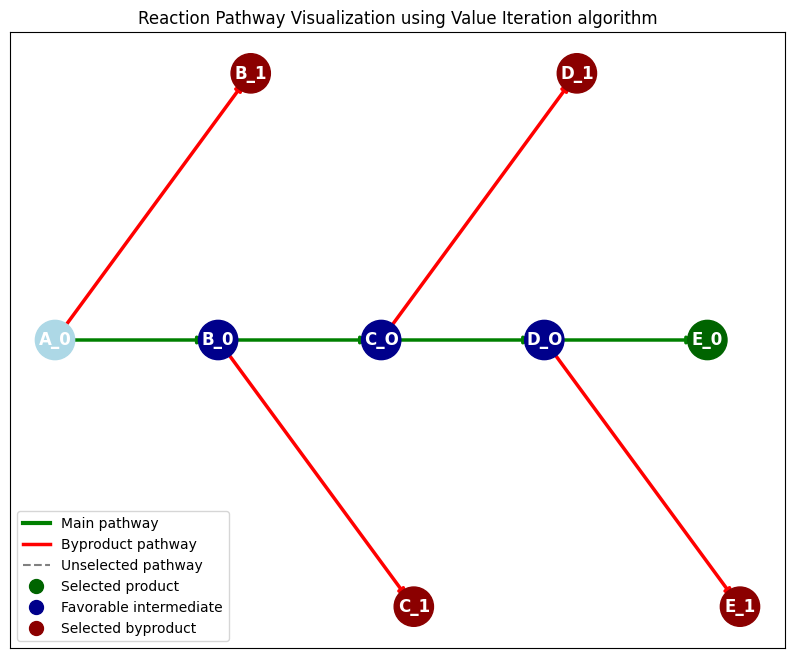

In [29]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_reaction_pathway(states, actions, policy, byproducts, node_labels, pos, str1):
    G = nx.DiGraph()

    # Add nodes
    for s in states:
        G.add_node(s)

    # Add edges with colors
    edge_colors = []
    edge_styles = []
    node_colors = []

    for s in states:
        for s_next in actions.get(s, []):
            G.add_edge(s, s_next)
            if policy.get(s) == s_next:
                edge_colors.append("green")  # Optimal pathway in green
                edge_styles.append("solid")
            elif s_next in byproducts:
                edge_colors.append("red")  # Byproduct pathways in red
                edge_styles.append("solid")
            else:
                edge_colors.append("gray")  # Other transitions
                edge_styles.append("dashed")

    # Assign node colors
    for s in states:
        if s == 4:  # Desired final product CH3OH
            node_colors.append("darkgreen")
        elif s in byproducts:
            node_colors.append("darkred")
        elif s in policy.values():
            node_colors.append("darkblue")
        else:
            node_colors.append("lightblue")

    #pos = nx.spring_layout(G, seed=42)  # Layout for better visualization

    # Draw the graph
    plt.figure(figsize=(10, 8))
    edges = list(G.edges())

    for i, (u, v) in enumerate(edges):
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=2.5, edge_color=edge_colors[i], style=edge_styles[i])

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=800)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12, font_weight='bold', font_color='white')

    # Legend elements
    legend_elements = [
        plt.Line2D([0], [0], color='green', lw=3, label='Main pathway'),
        plt.Line2D([0], [0], color='red', lw=2.5, label='Byproduct pathway'),
        plt.Line2D([0], [0], color='gray', lw=1.5, linestyle='dashed', label='Unselected pathway'),
        plt.Line2D([0], [0], marker='o', color='darkgreen', markersize=10, linestyle='', label='Selected product '),
        plt.Line2D([0], [0], marker='o', color='darkblue', markersize=10, linestyle='', label='Favorable intermediate'),
        plt.Line2D([0], [0], marker='o', color='darkred', markersize=10, linestyle='', label='Selected byproduct')
    ]

    plt.legend(handles=legend_elements, loc='lower left', fontsize=10)
    plt.title(f"Reaction Pathway Visualization using {str1}")
    plt.show()




# Call visualization function
byproducts = [5, 6,7,8]  # Nodes that are undesired pathways
str1 = "Value Iteration algorithm"
visualize_reaction_pathway(states, actions, policy_vi, byproducts, node_labels,pos, str1)


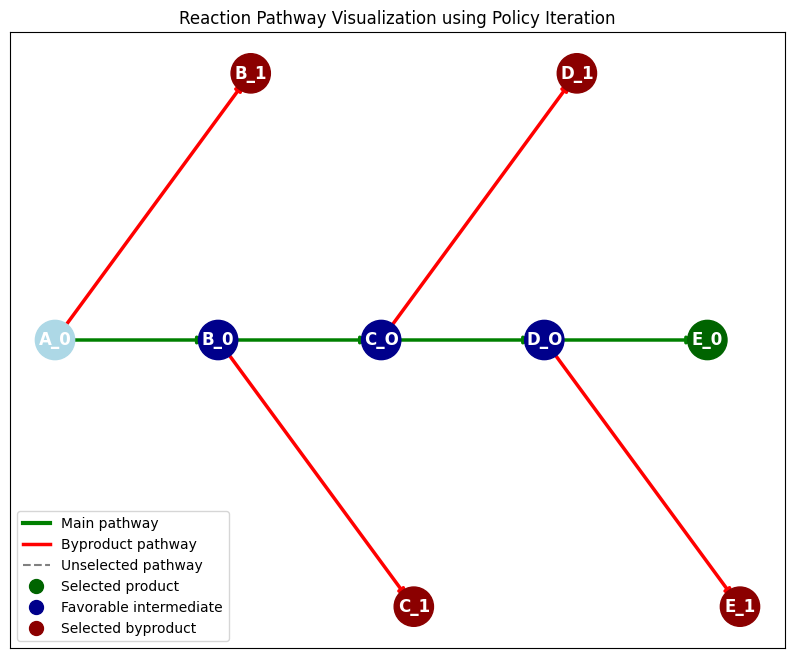

In [30]:
# Call visualization function
byproducts = [5, 6,7,8]  # Nodes that are undesired pathways
str2 = "Policy Iteration"
visualize_reaction_pathway(states, actions, policy_hpi, byproducts, node_labels,pos, str2)

We can see that the optimal Reaction Pathway using both the algorithm is
A_0 → B_0 → C_O → D_O → E_0.

## Changing the Reward Function

Definition: The **success rate** is the probability of reaching the desired product $E_0$  starting from the initial state $A_0$.

The above definition of success rate is without penalizing the byproducts. The value fucntion V will give me the success rate if the reward function for the above problem is as follows.
* $R(s^{next}) =\{ E_0 :1,\text{ rest }:0 \}$

In [31]:
R = {4: 1 , 5:0, 6: 0,7:0, 8: 0}  # Rewards
default_reward = 0  # Small reward for other states
#visualize_mdp(states, actions, P,R, gamma,node_labels,pos)
V_vi, policy_vi = value_iteration(states, actions, P, R, gamma, default_reward)
print(" For Reward function R = ", R)
print("============================")
print("Value Iteration:")
print(V_vi, policy_vi)
print_pathway(policy_vi)

print()
V_hpi,policy_hpi = policy_iteration()
print("Howard Policy Iteration:")
print(V_hpi, policy_hpi)
print_pathway(policy_hpi)

print()


 For Reward function R =  {4: 1, 5: 0, 6: 0, 7: 0, 8: 0}
Value Iteration:
{0: 0.07716375, 1: 0.09025, 2: 0.11875, 3: 0.25, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0} {0: 1, 1: 2, 2: 3, 3: 4, 4: None, 5: None, 6: None, 7: None, 8: None}
Optimal Reaction Pathway:
A_0 → B_0 → C_O → D_O → E_0

Howard Policy Iteration:
{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.25, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0} {0: 1, 1: 2, 2: 3, 3: 4, 4: None, 5: None, 6: None, 7: None, 8: None}
Optimal Reaction Pathway:
A_0 → B_0 → C_O → D_O → E_0



We can calculate the success rate for R:

$R(s^{next}) =\{ E_0 :1,\text{ rest }:0 \}$

* For Value iteration : $7.7\% $

* For Policy iteration : $ 0\% $

and optimal path for both algorithms is

$ A_0 → B_0 → C_O → D_O → E_0$.

Consider the success rate when reward fucntion penalizes
 $R ={4:+1,\text{ byproducts }:-0.5}$

In [32]:
R = {4: 1 , 5:-0.5, 6: -0.5,7:-0.5, 8: -0.5}  # Rewards
default_reward = 0  # Small reward for other states
#visualize_mdp(states, actions, P,R, gamma,node_labels,pos)
V_vi, policy_vi = value_iteration(states, actions, P, R, gamma, default_reward)

print(" For Reward function R = ", R)
print("============================")

print("Value Iteration:")
print(V_vi, policy_vi)
print_pathway(policy_vi)

print()
V_hpi,policy_hpi = policy_iteration()
print("Howard Policy Iteration:")
print(V_hpi, policy_hpi)
print_pathway(policy_hpi)

print()


 For Reward function R =  {4: 1, 5: -0.5, 6: -0.5, 7: -0.5, 8: -0.5}
Value Iteration:
{0: -0.336531875, 1: -0.335125, 2: -0.309375, 3: -0.125, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0} {0: 1, 1: 2, 2: 3, 3: 4, 4: None, 5: None, 6: None, 7: None, 8: None}
Optimal Reaction Pathway:
A_0 → B_0 → C_O → D_O → E_0

Howard Policy Iteration:
{0: -0.05, 1: -0.1, 2: -0.25, 3: -0.125, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0} {0: 1, 1: 2, 2: 3, 3: 4, 4: None, 5: None, 6: None, 7: None, 8: None}
Optimal Reaction Pathway:
A_0 → B_0 → C_O → D_O → E_0



We can calculate the success rate from here:
* For Value iteration : $-33.6\% $
* For Policy iteration : $ -5\% $.

Clearly these aren't meaningful values.

**Conclusion**

* We saw the effect of three different reward functions, and noted that for each of them the optimal reaction pathway is the same, i.e. $ A_0 → B_0 → C_O → D_O → E_0$.
* Only in one of the reward function gave some meaningful value of success rate.

* The success rate for reaching $E_0$  is low (7.7% or 0%), indicating that the reaction pathway design or transition probabilities may need improvement.